# Online Retail Data Analysis

In [31]:
import pandas as pd;
import seaborn as sns;
import numpy as np;
from matplotlib import pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import association_rules
import networkx as nx

In [32]:
data=pd.read_csv("OnlineRetail.csv")
data.columns
data.describe()#summary statistics of numerical data

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [33]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [34]:
data.shape #8 columns 541909 rows

(541909, 8)

Unit price and quantity values are negative for some items

In [35]:
data['InvoiceNo'].nunique() #number of invoices

25900

### Data Cleaning And Preprocessing

In [36]:
#Convert to proper format
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
data['Total_Sales'] = data.Quantity*data.UnitPrice
data.CustomerID = data.CustomerID.astype('Int64')

In [37]:
#data preprocessing
data.std()==0
data=data.drop(data.std()[data.std()==0].index,axis=1)#removing numerical zero variance
categorical_var=list(data.dtypes[data.dtypes == object].index)
zero_cardinality = [] 

for i in categorical_var: # for each categorical variables
    if len(data[i].value_counts().index) == 1: # check how many levels it has and if it is one
        zero_cardinality.append(i) # the variable has zero variance as the cardinality is one 
        # append it to the list of categorical variables with zero variation
        
data= data.drop(zero_cardinality,axis=1)#drop zero variance

categorical_var=list(data.dtypes[data.dtypes == object].index)
high_cardinality = [] 
for i in categorical_var:
    if len(data[i].value_counts().index)>200:
        high_cardinality.append(i)
#high_cardinality# no need to drop as it is considering string type variables
#data=data.drop(high_cardinality,axis=1)

In [38]:
#check missing values
data_missing=data.isna().sum()
pers_missing=data_missing*100/len(data)
pers_missing

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
Total_Sales     0.000000
dtype: float64

In [39]:
#checking accounts with negative and zero unit price
data[data['UnitPrice']<=0]
#As it as bad debt adjstment remove those rows
data=data[~(data['UnitPrice']<=0)]

In [40]:
len(data[data['Quantity']<0]) # 1.9% of data has negative quantity, removing them
data=data[~(data['Quantity']<0)]

In [41]:
data[data['CustomerID'].isnull()]#133359 rows missing dropping for now
data=data[~(data['CustomerID'].isnull())]#397924 rows left

In [42]:
data_missing=data.isna().sum()
data_missing#none are missing now

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Total_Sales    0
dtype: int64

In [43]:
#check rows with same stock code but different descipitions
data_descrip = data.groupby(['StockCode','Description']).count().reset_index()
#for these column item same but description entered different due to manual error
data[data['StockCode'] == data_descrip.StockCode.value_counts()[data_descrip.StockCode.value_counts()>1].reset_index()['index'][211]]['Description'].unique()#change '2' to display more erroneous results


array(['SPACEBOY WALL ART', 'WALL ART SPACEBOY'], dtype=object)

In [44]:
#remove the above inconsitency
uniq_desc_tbl=data[['StockCode','Description']].groupby(['StockCode']).apply(pd.DataFrame.mode).reset_index(drop=True)
uniq_desc_tbl
query = ''' select d.InvoiceNo, d.StockCode, d.Total_Sales, u.Description, d.Quantity,d.InvoiceDate,d.UnitPrice,d.CustomerID,d.Country from data as d
 INNER JOIN uniq_desc_tbl as u ON d.StockCode=u.StockCode'''
new_data=pysqldf(query)
new_data.columns

Index(['InvoiceNo', 'StockCode', 'Total_Sales', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

###### Removing Spaces from descriptions and removed credit card transactions 

In [45]:
new_data['Description']=new_data['Description'].str.strip()
new_data['Country']=new_data['Country'].str.strip()
new_data['Country'] = new_data['Country'].astype('category')
new_data['InvoiceNo']=new_data['InvoiceNo'].astype('str')
new_data=new_data[~new_data['InvoiceNo'].str.contains('C')]

### Association Rule Mining

###### Mine Rules for top 3 countries

In [184]:
grp=new_data.groupby(['Country']).count()
grp.nlargest(3,'InvoiceNo')

,InvoiceNo,StockCode,Amount,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
Country,,,,,,,,
United Kingdom,354317,354317,354317,354317,354317,354317,354317,354317
Germany,9040,9040,9040,9040,9040,9040,9040,9040
France,8341,8341,8341,8341,8341,8341,8341,8341


#### FRANCE

###### Filtering Out CountryWise for faster processing 

In [185]:
basket_france=new_data[new_data['Country']=='France'].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_france

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Encoding to 0/1 bit and dropping unnecessary columns 

In [186]:
def encode_unit(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
baskets=basket_france.applymap(encode_unit)
baskets.drop('POSTAGE',inplace=True,axis=1)  


##### Applying Apriori algorithm and filtering out rules on the basis of high support,confidence,lift 

In [187]:
frequent_items=apriori(baskets,min_support=0.1,use_colnames=True)
rules=association_rules(frequent_items,metric="lift",min_threshold=1)
rules[(rules['confidence']>0.7) & (rules['lift']>5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(SET/6 RED SPOTTY PAPER CUPS),(SET/20 RED RETROSPOT PAPER NAPKINS),0.138817,0.133676,0.102828,0.740741,5.541311,0.084271,3.341535
5,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER CUPS),0.133676,0.138817,0.102828,0.769231,5.541311,0.084271,3.731791
6,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER PLATES),0.133676,0.128535,0.102828,0.769231,5.984615,0.085646,3.776350
7,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.128535,0.133676,0.102828,0.800000,5.984615,0.085646,4.331620
8,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.138817,0.128535,0.123393,0.888889,6.915556,0.105550,7.843188
9,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.128535,0.138817,0.123393,0.960000,6.915556,0.105550,21.529563
10,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612
11,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.102828,0.138817,0.100257,0.975000,7.023611,0.085983,34.447301
12,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.123393,0.133676,0.100257,0.812500,6.078125,0.083762,4.620394
13,(SET/20 RED RETROSPOT PAPER NAPKINS),"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",0.133676,0.123393,0.100257,0.750000,6.078125,0.083762,3.506427


##### Get top 5 rules

In [188]:

rules_tran=pd.DataFrame(rules[['antecedents','consequents','lift','confidence','support']])
#filter top rules
top_rules_fr=rules_tran.groupby(['antecedents', 'consequents']).first().reset_index().sort_values(['support', 'confidence', 'lift'],ascending=False).head()

#####  Support vs Confidence plot

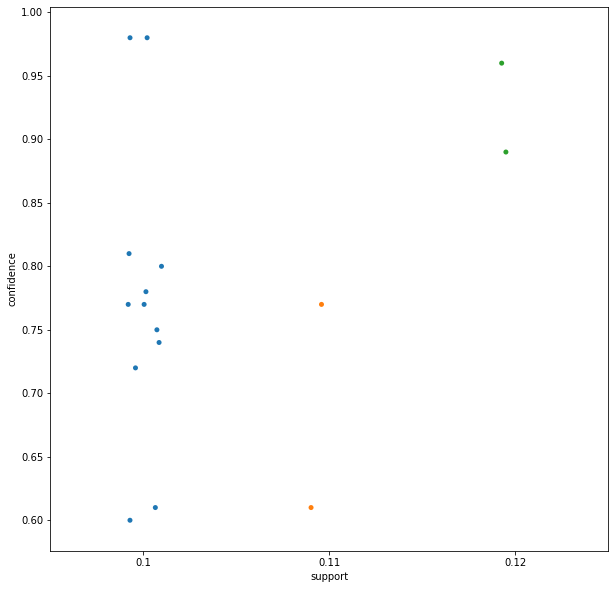

In [189]:
plt.figure(figsize=(10,10))
g=sns.stripplot(round(rules_tran['support'],2), round(rules_tran['confidence'],2),data=rules_tran,jitter=True)
plt.show()

##### Showing Associations among top 5 items bought together in 'France'

In [190]:
def draw_rules(rules,country):
    plt.figure(figsize=(15,10))
    G=nx.DiGraph()
    node_color=[]
    rule_no=['R0','R1','R2','R3','R4']#,'R5','R6','R7','R8','R9','R10']
    for i in range(len(rule_no)):
        G.add_nodes_from([rule_no[i]])
        for a in rules.iloc[i]['antecedents']:
            G.add_nodes_from([a])
            G.add_edge(a, rule_no[i])
        for c in rules.iloc[i]['consequents']:
            G.add_nodes_from([c])
            G.add_edge(rule_no[i], c)
    edges=G.edges()
    for node in G:
        flag_rule=0;
        for i in rule_no:
            if i==node:
                flag_rule=1
        if flag_rule==1:
            node_color.append('red')
        else:
            node_color.append('green')
    pos=nx.planar_layout(G)
    nx.draw(G,pos,edges=edges, font_size=18,node_color=node_color, with_labels=False)
    for i in pos: 
           pos[i][1] += 0.03
    nx.draw_networkx_labels(G,pos)
    plt.title('Top 5 Associations for '+country,size=30)
    plt.show()

C:\Users\Messi\Anaconda3\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
C:\Users\Messi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Messi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


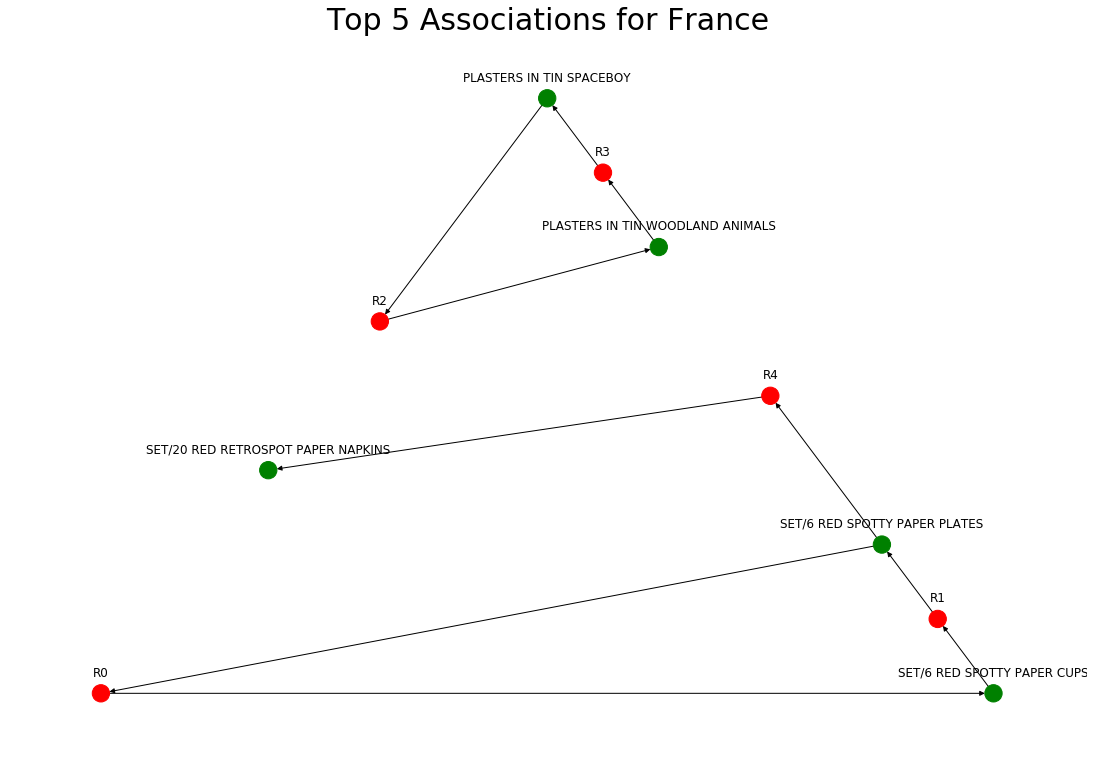

In [191]:
draw_rules(top_rules_fr,'France')

In [192]:
top_rules_fr

,antecedents,consequents,lift,confidence,support
11,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),6.915556,0.960000,0.123393
5,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),6.915556,0.888889,0.123393
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),4.491411,0.773585,0.105398
1,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),4.491411,0.611940,0.105398
10,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),5.984615,0.800000,0.102828


#### GERMANY

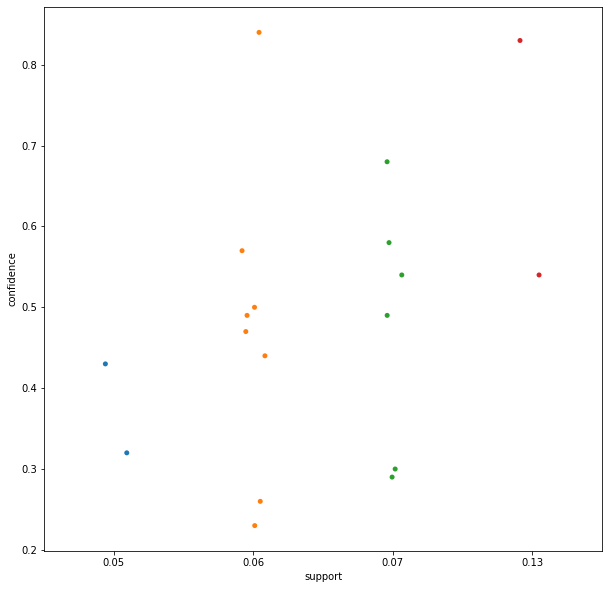

In [193]:
basket_gm=new_data[new_data['Country']=='Germany'].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
baskets_gm=basket_gm.applymap(encode_unit)
baskets_gm.drop('POSTAGE',inplace=True,axis=1)  
frequent_items_gm=apriori(baskets_gm,min_support=0.05,use_colnames=True) #lower cutoff for support for Germany
rules_gm=association_rules(frequent_items_gm,metric="lift",min_threshold=1)
rules_tran_gm=pd.DataFrame(rules_gm[['antecedents','consequents','lift','confidence','support']])
#filter top rules
top_rules_gm=rules_tran_gm.groupby(['antecedents', 'consequents']).first().reset_index().sort_values(['lift'],ascending=False).head()
plt.figure(figsize=(10,10))
sns.stripplot(round(rules_tran_gm['support'],2), round(rules_tran_gm['confidence'],2),data=rules_tran_gm,jitter=True)
plt.show()

##### Top Rules for Germany

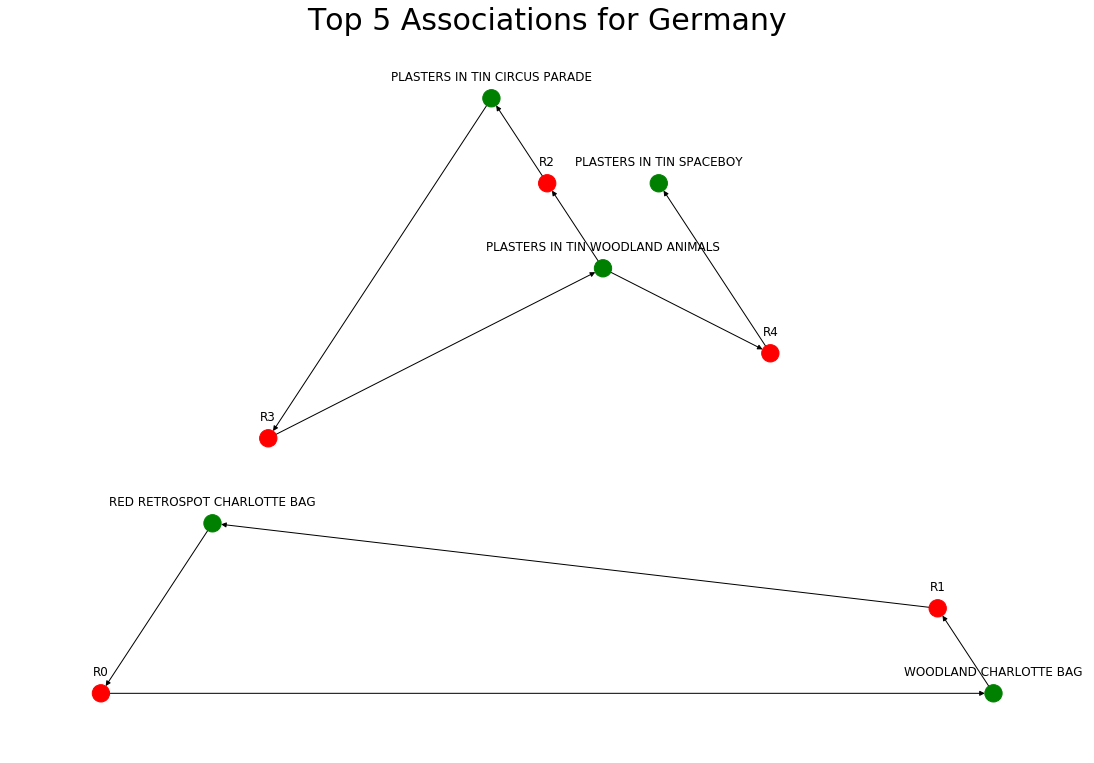

In [194]:
draw_rules(top_rules_gm,'Germany')

In [195]:
top_rules_gm

,antecedents,consequents,lift,confidence,support
16,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),6.648168,0.843750,0.059081
15,(WOODLAND CHARLOTTE BAG),(RED RETROSPOT CHARLOTTE BAG),6.648168,0.465517,0.059081
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),4.242887,0.492063,0.067834
3,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),4.242887,0.584906,0.067834
2,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),4.145125,0.444444,0.061269


#### United Kingdom

In [199]:
basket_uk=new_data[new_data['Country']=='United Kingdom'].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
baskets_uk=basket_uk.applymap(encode_unit)
baskets_uk.drop('POSTAGE',inplace=True,axis=1)  
frequent_items_uk=apriori(baskets_uk,min_support=0.1,use_colnames=True) #lower cutoff for support for UK
rules_uk=association_rules(frequent_items_uk,metric="lift",min_threshold=1)
rules_uk

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


###### No rule with lift more than 1 i.e no significant lift for UK